In [11]:
import numpy as np
import pandas as pd 
import torch 
import matplotlib.pyplot as plt 

In [12]:
import os 
os.chdir('/kaggle/input/data-diff') #Define Data Directory

In [13]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np

class SuperresDataset(Dataset):
    def __init__(self, hr_images, lr_images, max_images=None):
        """
        Initialize the SuperresDataset.
        Parameters:
        - hr_images (numpy array): High-resolution images of shape (N, 1, 128, 128).
        - lr_images (numpy array): Low-resolution images of shape (N, 1, 64, 64).
        - max_images (int, optional): Maximum number of images to use.
        """
        self.hr_images = torch.from_numpy(self.normalize(hr_images))
        self.lr_images = torch.from_numpy(self.normalize(lr_images))
        
        if max_images is not None:
            self.hr_images = self.hr_images[:max_images]
            self.lr_images = self.lr_images[:max_images]
        
    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        """
        Get the interpolated low-resolution image and high-resolution image at the specified index.
        Parameters:
        - idx (int): Index of the image to retrieve.
        Returns:
        - tuple of torch.Tensor: Interpolated low-resolution image and high-resolution image.
        """
        hr = self.hr_images[idx]
        lr = self.lr_images[idx]
        
        # Interpolate LR image to the size of HR image
        lr_interpolated = F.interpolate(lr.unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False)
        
        return lr_interpolated.squeeze(0), hr

    @staticmethod
    def normalize(x):
        """
        Normalize the images to [0, 1] range.
        """
        return (x - np.min(x)) / (np.max(x) - np.min(x))

In [14]:
hr_images = np.load('HR_new.npy')
lr_images = np.load('LR_new.npy')

In [15]:
import numpy as np
import torch
from torch.utils.data import DataLoader

total_samples = len(hr_images)
train_size = int(0.90 * total_samples)
test_size = total_samples - train_size
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_indices, test_indices = indices[:train_size], indices[train_size:]

train_dataset = SuperresDataset([hr_images[i] for i in train_indices], [lr_images[i] for i in train_indices])
test_dataset = SuperresDataset([hr_images[i] for i in test_indices], [lr_images[i] for i in test_indices])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
dataiter = iter(train_loader)
batch = next(dataiter)

hr_images = batch[1]
min_val = hr_images.min().item()
max_val = hr_images.max().item()

print(f"Min value: {min_val}, Max value: {max_val}")

Min value: 0.04195600003004074, Max value: 0.9274583458900452


In [17]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return out

class Generator(nn.Module):
    def __init__(self, num_channels=1, num_blocks=16):
        super(Generator, self).__init__()
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=4)
        self.relu = nn.ReLU(inplace=True)
        
        res_blocks = [ResidualBlock(64) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*res_blocks)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, num_channels, kernel_size=9, padding=4)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        residual = x
        x = self.res_blocks(x)
        x = self.bn2(self.conv2(x))
        x += residual
        x = self.conv3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, num_channels=1):
        super(Discriminator, self).__init__()
        
        def discriminator_block(in_channels, out_channels, stride):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.BatchNorm2d(out_channels),
            )
        
        self.model = nn.Sequential(
            discriminator_block(num_channels, 64, 1),
            discriminator_block(64, 64, 2),
            discriminator_block(64, 128, 1),
            discriminator_block(128, 128, 2),
            discriminator_block(128, 256, 1),
            discriminator_block(256, 256, 2),
            discriminator_block(256, 512, 1),
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.model(x).view(batch_size))

In [20]:
import torch
from tqdm import tqdm
import torch.nn as nn
import os

def train_srgan(generator, discriminator, train_loader, content_criterion, adversarial_criterion, 
                gen_optimizer, disc_optimizer, scheduler, device, num_epochs=30, save_dir='/kaggle/working/'):
    generator.to(device)
    discriminator.to(device)
    
    best_total_loss = float('inf')
    os.makedirs(save_dir, exist_ok=True)
    
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        
        running_g_loss = 0.0
        running_d_loss = 0.0
        total_batches = len(train_loader)
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        
        for data in pbar:
            lr, hr = data[0].to(device), data[1].to(device)
            
            # Train Discriminator
            disc_optimizer.zero_grad()
            
            sr = generator(lr)
            real_output = discriminator(hr)
            fake_output = discriminator(sr.detach())
            
            d_loss_real = adversarial_criterion(real_output, torch.ones_like(real_output))
            d_loss_fake = adversarial_criterion(fake_output, torch.zeros_like(fake_output))
            d_loss = d_loss_real + d_loss_fake
            
            d_loss.backward()
            disc_optimizer.step()
            
            # Train Generator
            gen_optimizer.zero_grad()
            
            sr = generator(lr)
            fake_output = discriminator(sr)
            
            content_loss = content_criterion(sr, hr)
            adversarial_loss = adversarial_criterion(fake_output, torch.ones_like(fake_output))
            g_loss = content_loss + 1e-3 * adversarial_loss  # The factor 1e-3 balances the two losses
            
            g_loss.backward()
            gen_optimizer.step()
            
            running_g_loss += g_loss.item()
            running_d_loss += d_loss.item()
            
            pbar.set_postfix({'G_loss': f'{g_loss.item():.8f}', 'D_loss': f'{d_loss.item():.8f}'})
        
        # Step the scheduler after each epoch
        scheduler.step()
        
        # Calculate average losses for the epoch
        epoch_g_loss = running_g_loss / total_batches
        epoch_d_loss = running_d_loss / total_batches
        epoch_total_loss = epoch_g_loss + epoch_d_loss
        
        print(f'Epoch {epoch + 1}/{num_epochs}, G_Loss: {epoch_g_loss:.8f}, D_Loss: {epoch_d_loss:.8f}, Total Loss: {epoch_total_loss:.8f}')
        
        # Save the best model based on total loss
        if epoch_total_loss < best_total_loss:
            best_total_loss = epoch_total_loss
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'gen_optimizer_state_dict': gen_optimizer.state_dict(),
                'disc_optimizer_state_dict': disc_optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'g_loss': epoch_g_loss,
                'd_loss': epoch_d_loss,
                'total_loss': epoch_total_loss,
            }, os.path.join(save_dir, 'best_model.pth'))
            print(f'New best model saved with Total Loss: {epoch_total_loss:.8f}')
    
    print('Finished Training')


In [35]:
import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.nn.parallel import DataParallel



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


generator = Generator(num_channels=1)  
discriminator = Discriminator(num_channels=1) 


if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    generator = DataParallel(generator)
    discriminator = DataParallel(discriminator)

generator = generator.to(device)
discriminator = discriminator.to(device)


content_criterion = nn.L1Loss().to(device)
adversarial_criterion = nn.BCELoss().to(device)

gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)


scheduler = StepLR(gen_optimizer, step_size=10, gamma=0.5)
train_srgan(generator, discriminator, train_loader, content_criterion, adversarial_criterion, 
            gen_optimizer, disc_optimizer, scheduler, device)

Using device: cuda
Using 2 GPUs!


Epoch 1/30:   0%|          | 0/160 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/30, G_Loss: 0.04083317, D_Loss: 0.44946400, Total Loss: 0.49029717
New best model saved with Total Loss: 0.49029717


Epoch 2/30, G_Loss: 0.02626978, D_Loss: 0.19935674, Total Loss: 0.22562651
New best model saved with Total Loss: 0.22562651


Epoch 3/30, G_Loss: 0.03017332, D_Loss: 0.02814952, Total Loss: 0.05832284
New best model saved with Total Loss: 0.05832284


Epoch 4/30, G_Loss: 0.02881257, D_Loss: 0.07385678, Total Loss: 0.10266935


Epoch 5/30, G_Loss: 0.02796375, D_Loss: 0.02374322, Total Loss: 0.05170697
New best model saved with Total Loss: 0.05170697


Epoch 6/30, G_Loss: 0.03000011, D_Loss: 0.03399078, Total Loss: 0.06399089


Epoch 7/30, G_Loss: 0.02882246, D_Loss: 0.01790208, Total Loss: 0.04672455
New best model saved with Total Loss: 0.04672455


Epoch 8/30, G_Loss: 0.02509651, D_Loss: 0.01468499, Total Loss: 0.03978150
New best model saved with Total Loss: 0.03978150


Epoch 9/30, G_Loss: 0.02556503, D_Loss: 0.00557627, Total Loss: 0.03114130
New best model saved with Total Loss: 0.03114130


Epoch 10/30, G_Loss: 0.02653862, D_Loss: 0.00345813, Total Loss: 0.02999675
New best model saved with Total Loss: 0.02999675


Epoch 11/30, G_Loss: 0.02608648, D_Loss: 0.00469881, Total Loss: 0.03078528


Epoch 12/30, G_Loss: 0.02509805, D_Loss: 0.02278320, Total Loss: 0.04788125


Epoch 13/30, G_Loss: 0.01992674, D_Loss: 0.50945716, Total Loss: 0.52938390


Epoch 14/30, G_Loss: 0.02306107, D_Loss: 0.09722824, Total Loss: 0.12028932


Epoch 15/30, G_Loss: 0.02365796, D_Loss: 0.03378223, Total Loss: 0.05744019


Epoch 16/30, G_Loss: 0.02423955, D_Loss: 0.09267039, Total Loss: 0.11690994


Epoch 17/30, G_Loss: 0.02381367, D_Loss: 0.01428344, Total Loss: 0.03809711


Epoch 18/30, G_Loss: 0.02604778, D_Loss: 0.01651305, Total Loss: 0.04256083


Epoch 19/30, G_Loss: 0.02531676, D_Loss: 0.01306936, Total Loss: 0.03838612


Epoch 20/30, G_Loss: 0.02726745, D_Loss: 0.05657203, Total Loss: 0.08383948


Epoch 21/30, G_Loss: 0.02598532, D_Loss: 0.02555814, Total Loss: 0.05154346


Epoch 22/30, G_Loss: 0.02382044, D_Loss: 0.10930270, Total Loss: 0.13312314


Epoch 23/30, G_Loss: 0.02484890, D_Loss: 0.00686187, Total Loss: 0.03171076


Epoch 24/30, G_Loss: 0.02478171, D_Loss: 0.04667475, Total Loss: 0.07145647


Epoch 25/30, G_Loss: 0.02668163, D_Loss: 0.00959513, Total Loss: 0.03627676


Epoch 26/30, G_Loss: 0.02706927, D_Loss: 0.08577419, Total Loss: 0.11284345


Epoch 27/30, G_Loss: 0.02437130, D_Loss: 0.00606687, Total Loss: 0.03043817


Epoch 28/30, G_Loss: 0.02526452, D_Loss: 0.00218406, Total Loss: 0.02744858
New best model saved with Total Loss: 0.02744858


Epoch 29/30, G_Loss: 0.02419025, D_Loss: 0.01042589, Total Loss: 0.03461614


Epoch 30/30, G_Loss: 0.02448050, D_Loss: 0.02980867, Total Loss: 0.05428917
Finished Training


In [22]:
train_srgan(generator, discriminator, train_loader, content_criterion, adversarial_criterion, 
            gen_optimizer, disc_optimizer, scheduler, device)

Epoch 1/30, G_Loss: 0.00995389, D_Loss: 0.18840326, Total Loss: 0.19835715
New best model saved with Total Loss: 0.19835715


Epoch 2/30, G_Loss: 0.00563263, D_Loss: 0.76160158, Total Loss: 0.76723421


Epoch 3/30, G_Loss: 0.00480056, D_Loss: 0.77996924, Total Loss: 0.78476980


Epoch 4/30, G_Loss: 0.00292685, D_Loss: 0.99887503, Total Loss: 1.00180188


Epoch 5/30, G_Loss: 0.00261209, D_Loss: 1.14133297, Total Loss: 1.14394506


Epoch 6/30, G_Loss: 0.00247628, D_Loss: 1.13329370, Total Loss: 1.13576998


Epoch 7/30, G_Loss: 0.00261027, D_Loss: 1.10313663, Total Loss: 1.10574690


Epoch 8/30, G_Loss: 0.00264318, D_Loss: 0.95909849, Total Loss: 0.96174168


Epoch 9/30, G_Loss: 0.00256726, D_Loss: 1.02168280, Total Loss: 1.02425006


Epoch 10/30, G_Loss: 0.00265688, D_Loss: 0.96403753, Total Loss: 0.96669442


Epoch 11/30, G_Loss: 0.00367178, D_Loss: 0.50017438, Total Loss: 0.50384616


Epoch 12/30, G_Loss: 0.00297757, D_Loss: 0.80991932, Total Loss: 0.81289689


Epoch 13/30, G_Loss: 0.00369345, D_Loss: 0.48179490, Total Loss: 0.48548835


Epoch 14/30, G_Loss: 0.00464644, D_Loss: 0.19721242, Total Loss: 0.20185886


Epoch 15/30, G_Loss: 0.00552789, D_Loss: 0.07494128, Total Loss: 0.08046916
New best model saved with Total Loss: 0.08046916


Epoch 16/30, G_Loss: 0.00612000, D_Loss: 0.02417667, Total Loss: 0.03029667
New best model saved with Total Loss: 0.03029667


Epoch 17/30, G_Loss: 0.00612533, D_Loss: 0.06416745, Total Loss: 0.07029278


Epoch 18/30, G_Loss: 0.00661035, D_Loss: 0.02683476, Total Loss: 0.03344511


Epoch 19/30, G_Loss: 0.00685642, D_Loss: 0.00914078, Total Loss: 0.01599720
New best model saved with Total Loss: 0.01599720


Epoch 20/30, G_Loss: 0.00740365, D_Loss: 0.01807607, Total Loss: 0.02547972


Epoch 21/30, G_Loss: 0.00876732, D_Loss: 0.01186912, Total Loss: 0.02063644


Epoch 22/30, G_Loss: 0.00839344, D_Loss: 0.01227267, Total Loss: 0.02066612


Epoch 23/30, G_Loss: 0.00795833, D_Loss: 0.00778481, Total Loss: 0.01574314
New best model saved with Total Loss: 0.01574314


Epoch 24/30, G_Loss: 0.00841585, D_Loss: 0.00426361, Total Loss: 0.01267946
New best model saved with Total Loss: 0.01267946


Epoch 25/30, G_Loss: 0.00820852, D_Loss: 0.07271849, Total Loss: 0.08092701


Epoch 26/30, G_Loss: 0.00824234, D_Loss: 0.00554693, Total Loss: 0.01378927


Epoch 27/30, G_Loss: 0.00829801, D_Loss: 0.00928365, Total Loss: 0.01758166


Epoch 28/30, G_Loss: 0.00826665, D_Loss: 0.00534794, Total Loss: 0.01361459


Epoch 29/30, G_Loss: 0.00844450, D_Loss: 0.00971808, Total Loss: 0.01816258


Epoch 30/30, G_Loss: 0.00876501, D_Loss: 0.01263954, Total Loss: 0.02140455
Finished Training


In [11]:
save_path = "/kaggle/working/Generator.pth"
torch.save(generator.state_dict(), save_path)
print("Saved Successfully")

Saved Successfully


In [12]:
save_path = "/kaggle/working/Discriminator.pth"
torch.save(discriminator.state_dict(), save_path)
print("Saved Successfully")

Saved Successfully


In [34]:
import torch

def load_srgan_model(generator, discriminator, gen_optimizer, disc_optimizer, scheduler, device, model_path):
    checkpoint = torch.load(model_path, map_location=device)
    
    # Function to remove 'module.' prefix if it exists
    def remove_module_prefix(state_dict):
        return {k.replace('module.', ''): v for k, v in state_dict.items()}

    # Load generator state dict
    gen_state_dict = remove_module_prefix(checkpoint['generator_state_dict'])
    generator.load_state_dict(gen_state_dict)

    # Load discriminator state dict
    disc_state_dict = remove_module_prefix(checkpoint['discriminator_state_dict'])
    discriminator.load_state_dict(disc_state_dict)
    
    gen_optimizer.load_state_dict(checkpoint['gen_optimizer_state_dict'])
    disc_optimizer.load_state_dict(checkpoint['disc_optimizer_state_dict'])
    
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    epoch = checkpoint['epoch']
    g_loss = checkpoint['g_loss']
    d_loss = checkpoint['d_loss']
    total_loss = checkpoint['total_loss']
    
    print(f"Loaded model from epoch {epoch}")
    print(f"Generator Loss: {g_loss:.8f}")
    print(f"Discriminator Loss: {d_loss:.8f}")
    print(f"Total Loss: {total_loss:.8f}")
    
    return generator, discriminator, gen_optimizer, disc_optimizer, scheduler, epoch

# Usage example:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.00001)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(gen_optimizer, step_size=10, gamma=0.5)

model_path = '/kaggle/working/best_model.pth'
generator, discriminator, gen_optimizer, disc_optimizer, scheduler, epoch = load_srgan_model(
    generator, discriminator, gen_optimizer, disc_optimizer, scheduler, device, model_path
)

Loaded model from epoch 2
Generator Loss: 0.00831172
Discriminator Loss: 0.00168830
Total Loss: 0.01000002


/tmp/ipykernel_36/2345799647.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


In [30]:
train_srgan(generator, discriminator, train_loader, content_criterion, adversarial_criterion, 
            gen_optimizer, disc_optimizer, scheduler, device)

Epoch 1/30, G_Loss: 0.00827179, D_Loss: 0.00237070, Total Loss: 0.01064249
New best model saved with Total Loss: 0.01064249


Epoch 2/30, G_Loss: 0.00816800, D_Loss: 0.00321377, Total Loss: 0.01138177


Epoch 3/30, G_Loss: 0.00831172, D_Loss: 0.00168830, Total Loss: 0.01000002
New best model saved with Total Loss: 0.01000002


Epoch 4/30, G_Loss: 0.00833151, D_Loss: 0.00196013, Total Loss: 0.01029164


Epoch 5/30, G_Loss: 0.00893983, D_Loss: 0.00306464, Total Loss: 0.01200447


Epoch 6/30, G_Loss: 0.00939993, D_Loss: 0.00071642, Total Loss: 0.01011636


Epoch 7/30, G_Loss: 0.00978985, D_Loss: 0.00037812, Total Loss: 0.01016797


Epoch 8/30, G_Loss: 0.00969979, D_Loss: 0.00037031, Total Loss: 0.01007010


Epoch 9/30, G_Loss: 0.00970745, D_Loss: 0.00035015, Total Loss: 0.01005760


Epoch 10/30, G_Loss: 0.00982487, D_Loss: 0.00026822, Total Loss: 0.01009310


Epoch 11/30, G_Loss: 0.00987611, D_Loss: 0.00028551, Total Loss: 0.01016162


Epoch 12/30, G_Loss: 0.00997840, D_Loss: 0.00029933, Total Loss: 0.01027773


Epoch 13/30, G_Loss: 0.01014517, D_Loss: 0.00029240, Total Loss: 0.01043757


Epoch 14/30, G_Loss: 0.01179651, D_Loss: 0.00080243, Total Loss: 0.01259894


Epoch 15/30, G_Loss: 0.01139460, D_Loss: 0.00177022, Total Loss: 0.01316481


Epoch 16/30, G_Loss: 0.01030647, D_Loss: 0.02788146, Total Loss: 0.03818794


Epoch 17/30, G_Loss: 0.00955144, D_Loss: 0.00753848, Total Loss: 0.01708992


Epoch 18/30, G_Loss: 0.00987119, D_Loss: 0.00314483, Total Loss: 0.01301601


Epoch 19/30, G_Loss: 0.01010198, D_Loss: 0.00120116, Total Loss: 0.01130314


Epoch 20/30, G_Loss: 0.01022251, D_Loss: 0.03957902, Total Loss: 0.04980153


Epoch 21/30, G_Loss: 0.01041608, D_Loss: 0.01936132, Total Loss: 0.02977740


Epoch 22/30, G_Loss: 0.01062573, D_Loss: 0.00599392, Total Loss: 0.01661965


Epoch 23/30, G_Loss: 0.01200226, D_Loss: 0.00235176, Total Loss: 0.01435403


Epoch 24/30, G_Loss: 0.01019932, D_Loss: 0.00124707, Total Loss: 0.01144640


Epoch 25/30, G_Loss: 0.01027452, D_Loss: 0.00062287, Total Loss: 0.01089739


Epoch 26/30, G_Loss: 0.01039485, D_Loss: 0.00031709, Total Loss: 0.01071195


Epoch 27/30, G_Loss: 0.01033146, D_Loss: 0.00025908, Total Loss: 0.01059054


Epoch 28/30, G_Loss: 0.01045564, D_Loss: 0.00028231, Total Loss: 0.01073795


Epoch 29/30, G_Loss: 0.01075757, D_Loss: 0.00012926, Total Loss: 0.01088682


Epoch 30/30, G_Loss: 0.01104510, D_Loss: 0.01695203, Total Loss: 0.02799713
Finished Training


In [26]:
!pip install pytorch_msssim

In [31]:
import torch
import torch.nn as nn
from tqdm import tqdm
from pytorch_msssim import ssim
import math

def evaluate_generator(generator, test_loader, device):
    generator.eval()
    mse_criterion = nn.MSELoss()
    l1_criterion = nn.L1Loss()
    
    psnr_scores = []
    ssim_scores = []
    mse_scores = []
    l1_scores = []
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Evaluating Generator"):
            lr, hr = data[0].to(device), data[1].to(device)
            sr = generator(lr)
            
            # Ensure sr and hr have the same size
            if sr.size() != hr.size():
                sr = torch.nn.functional.interpolate(sr, size=hr.size()[2:], mode='bilinear', align_corners=False)
            
            # Calculate metrics for each image in the batch
            for i in range(sr.size(0)):
                sr_img = sr[i].unsqueeze(0)
                hr_img = hr[i].unsqueeze(0)
                
                # MSE
                mse = mse_criterion(sr_img, hr_img).item()
                mse_scores.append(mse)
                
                # PSNR
                psnr = 10 * math.log10(1 / mse)
                psnr_scores.append(psnr)
                
                # SSIM
                ssim_score = ssim(sr_img, hr_img, data_range=1.0, size_average=False).item()
                ssim_scores.append(ssim_score)
                
                # L1 Loss
                l1_loss = l1_criterion(sr_img, hr_img).item()
                l1_scores.append(l1_loss)
    
    # Calculate average scores
    avg_psnr = sum(psnr_scores) / len(psnr_scores)
    avg_ssim = sum(ssim_scores) / len(ssim_scores)
    avg_mse = sum(mse_scores) / len(mse_scores)
    avg_l1 = sum(l1_scores) / len(l1_scores)
    
    return {
        'psnr': psnr_scores,
        'ssim': ssim_scores,
        'mse': mse_scores,
        'l1': l1_scores,
        'avg_psnr': avg_psnr,
        'avg_ssim': avg_ssim,
        'avg_mse': avg_mse,
        'avg_l1': avg_l1
    }


results = evaluate_generator(generator, test_loader, device)

print(f"Average PSNR: {results['avg_psnr']:.2f}")
print(f"Average SSIM: {results['avg_ssim']:.4f}")
print(f"Average MSE: {results['avg_mse']:.6f}")
print(f"Average L1 Loss: {results['avg_l1']:.6f}")

Evaluating Generator: 100%|██████████| 18/18 [00:03<00:00,  4.99it/s]

Average PSNR: 26.52
Average SSIM: 0.5664
Average MSE: 0.002784
Average L1 Loss: 0.044891


In [101]:
print(len(test_loader))

9


In [32]:
print(f"Average PSNR: {results['avg_psnr']:.2f}")
print(f"Average SSIM: {results['avg_ssim']:.4f}")
print(f"Average MSE: {results['avg_mse']:.6f}")
print(f"Average L1 Loss: {results['avg_l1']:.6f}")

Average PSNR: 26.52
Average SSIM: 0.5664
Average MSE: 0.002784
Average L1 Loss: 0.044891


Input shape (lr): torch.Size([16, 1, 128, 128])
Ground truth shape (hr): torch.Size([16, 1, 128, 128])
Model output shape (sr): torch.Size([16, 1, 128, 128])
Resized model output shape (sr): torch.Size([16, 1, 128, 128])


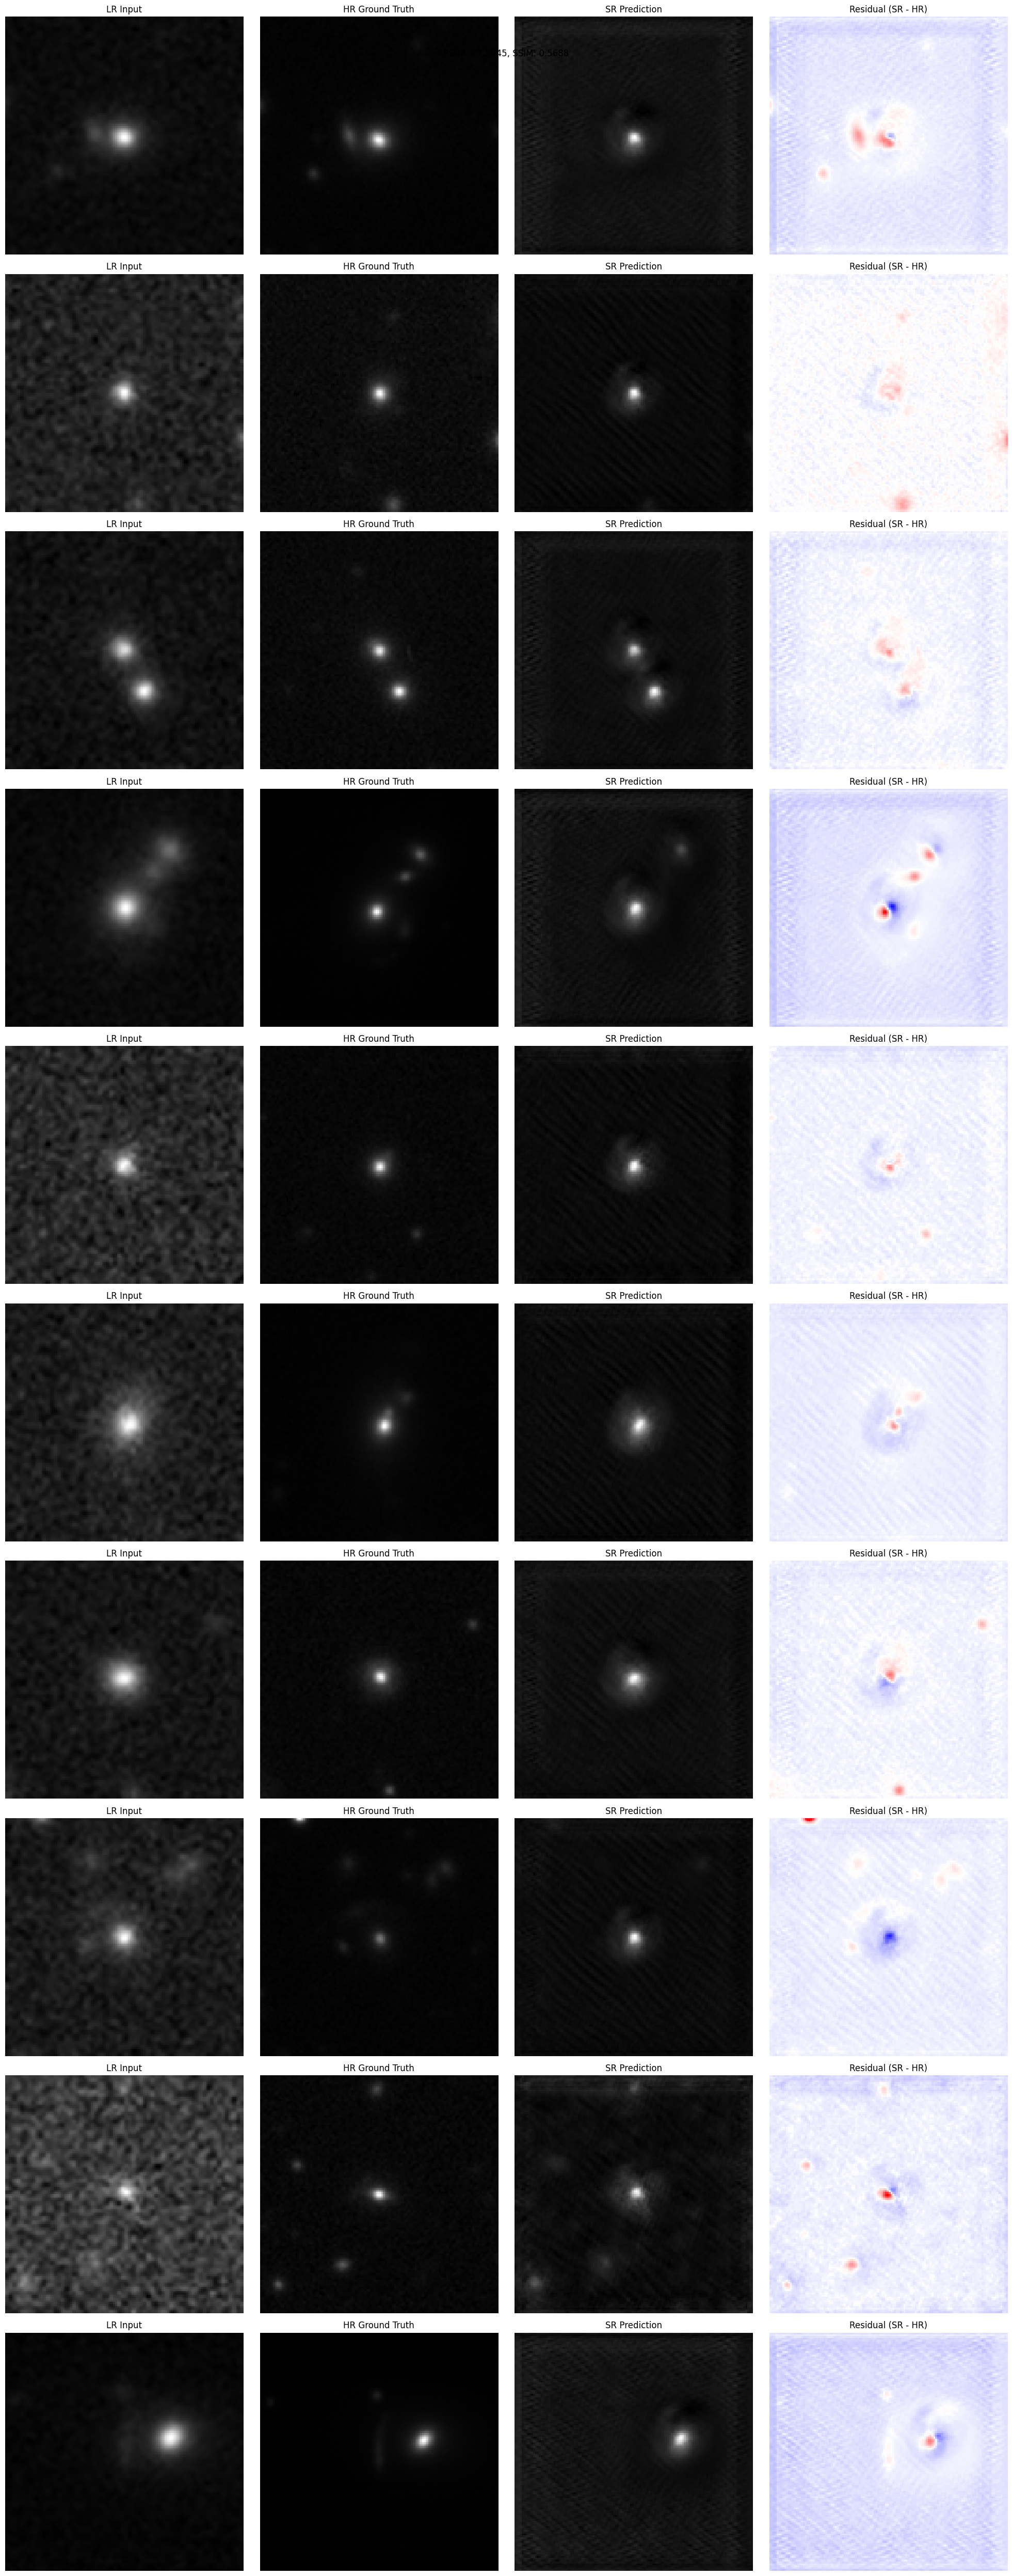

In [33]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def norma(x):
    return (x - x.min()) / (x.max() - x.min())

def plot_samples(model, test_loader, device, num_samples=10):
    model.eval()
    
    # Get a batch of images
    lr, hr = next(iter(test_loader))
    lr, hr = lr.to(device), hr.to(device)
    
    print(f"Input shape (lr): {lr.shape}")
    print(f"Ground truth shape (hr): {hr.shape}")
    
    with torch.no_grad():
        sr = model(lr)
    
    print(f"Model output shape (sr): {sr.shape}")
    
    # Ensure sr and hr have the same size
    if sr.size() != hr.size():
        sr = torch.nn.functional.interpolate(sr, size=hr.size()[2:], mode='bilinear', align_corners=False)
    
    print(f"Resized model output shape (sr): {sr.shape}")
    
    # Determine the number of samples to plot (minimum of batch size and num_samples)
    num_samples = min(lr.size(0), num_samples)
    
    # Calculate residuals
    residuals = hr - sr
    
    # Calculate metrics
    batch_psnr = []
    batch_ssim = []
    for i in range(num_samples):
        sr_np = norma(sr[i, 0].cpu().numpy())
        hr_np = norma(hr[i, 0].cpu().numpy())
        batch_psnr.append(psnr(hr_np, sr_np, data_range=1.0))
        batch_ssim.append(ssim(hr_np, sr_np, data_range=1.0))
    
    avg_psnr = np.mean(batch_psnr)
    avg_ssim = np.mean(batch_ssim)
    
    # Plot the images
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    
    # Ensure axes is always 2D, even when num_samples is 1
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        # LR image
        axes[i, 0].imshow(lr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 0].set_title('LR Input')
        axes[i, 0].axis('off')
        # HR image
        axes[i, 1].imshow(hr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 1].set_title('HR Ground Truth')
        axes[i, 1].axis('off')
        # SR prediction
        axes[i, 2].imshow(sr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 2].set_title('SR Prediction')
        axes[i, 2].axis('off')
        # Residual map
        axes[i, 3].imshow(residuals[i, 0].cpu().numpy(), cmap='bwr', vmin=-0.5, vmax=0.5)
        axes[i, 3].set_title('Residual (SR - HR)')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}')
    plt.show()

# Usage
plot_samples(generator, test_loader, device, num_samples=10)  # Requesting 10 samples
